<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: set up GPU runtime and install packages


*   the [pytorch segmentation models](https://github.com/qubvel/segmentation_models.pytorch) for pretrained model backbones
*   the [albumentations](https://albumentations.ai/) package for industrial-level image augmentations particularly good for segmentations
# *   update the open CV package



In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2cf1d1532a80f757106510982511c554d92ca3b312a2f39887a9713bf5ad8d24
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=fb66845809a37d6a91515f9a598073c8dda9b61be86fbc79e1deab5738896416
  Stored in directory: /root/.cache/pip/w

Download the human segmentation dataset - segment the human object in the front ground <p>

https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git
# in this github dataset, the size of the image and the correpongding mask can be different
# can cause error if use albumentations.Resize()
# use the cv2.resize() method to fix it
# or check the documentation of albumentations at https://albumentations.ai/docs/

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 21.59 MiB/s, done.
Resolving deltas: 100% (3/3), done.


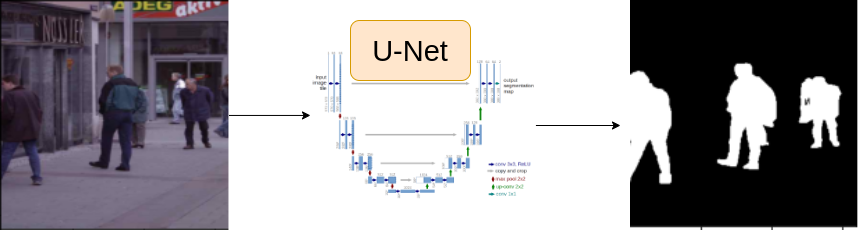

# Step 2: Imports the packages

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')
# add the path of the github repository to the system path list as that the python interpreter can see the files

In [4]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/Human-Segmentation-Dataset-master']


In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Step 3: Setup Configurations

In [6]:
# check the models at https://github.com/qubvel/segmentation_models.pytorch

CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 30
LR = 0.002
IMAGE_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[5]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 # scale to (0,1)
mask = cv2.resize(mask,(IMAGE_SIZE, IMAGE_SIZE))

(-0.5, 255.5, 255.5, -0.5)

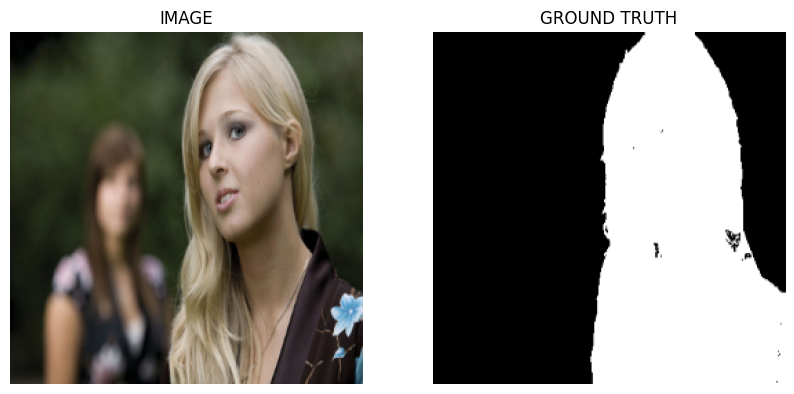

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)
ax1.axis('off')
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')
ax2.axis('off')

In [10]:
# 80% - 20% split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=100)

# Step 4 : Define the augmentation functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)])


In [13]:
def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE)])

# Step 5: Create custom dataset 

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,)
    mask = cv2.resize(mask, (IMAGE_SIZE,IMAGE_SIZE))
    mask = np.expand_dims(mask, axis=-1) # (h,w) -> (h,w,c)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # as dict
      image = data['image']
      mask = data['mask']

    # change to channel first: (h,w,c) -> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask)  / 255.0

    return image, mask



In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(val_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


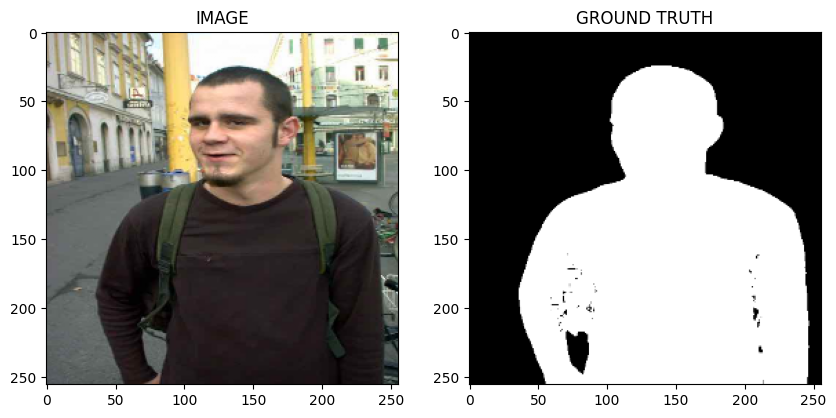

In [18]:
# change the index to get different image and mask
idx = 15
image, mask = trainset[idx]
# use the function from helper.py
helper.show_image(image, mask)

# Step 6: batch the dataset and load data batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [21]:
print(f'total # of batches in train: {len(trainloader)}')
print(f'total # of batches in validation: {len(validloader)}')

total # of batches in train: 15
total # of batches in validation: 4


In [22]:
# get one batch

for image, mask in trainloader:
  break

print(f'train batch image shape: {image.shape}')
print(f'train batch mask shape: {mask.shape}')


train batch image shape: torch.Size([16, 3, 256, 256])
train batch mask shape: torch.Size([16, 1, 256, 256])


In [23]:
for image, mask in validloader:
  break

print(f'validation batch image shape: {image.shape}')
print(f'validation batch mask shape: {mask.shape}')

validation batch image shape: torch.Size([16, 3, 256, 256])
validation batch mask shape: torch.Size([16, 1, 256, 256])


# Step 7: Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [24]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [39]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes= 1, # only human from background - 1 class
        activation=None # output logits
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks == None:
      return logits
    else:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2



In [40]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Step 8: Create Train and Validation Function 

In [41]:
def train_fn(data_loader, model, optimizer):
  model.train() # set the model to train mode which allows dropout and batch normalization
  total_loss = 0.0

  for image_batch, mask_batch in tqdm(data_loader): # use tqdm to show a process bar
    image_batch = image_batch.to(DEVICE)
    mask_batch = mask_batch.to(DEVICE)

    optimizer.zero_grad() # clear the gradients in the previous step
    logits, loss = model(image_batch, mask_batch)
    loss.backward() # get the gradients
    optimizer.step()

    total_loss += loss.item() # update the total loss, the item() method gets the value from GPU back to CPU
    # total loss value is on CPU RAM
  
  return total_loss / len(data_loader)


In [42]:
def eval_fn(data_loader, model):
  model.eval() # set the model to evaluation mode to shut down dropout and batch normalization
  total_loss = 0.0

  with torch.no_grad():

    for image_batch, mask_batch in tqdm(data_loader): # use tqdm to show a process bar
      image_batch = image_batch.to(DEVICE)
      mask_batch = mask_batch.to(DEVICE)

      logits, loss = model(image_batch, mask_batch)

      total_loss += loss.item() # update the total loss, the item() method gets the value from GPU back to CPU
      # total loss value is on CPU RAM
  
  return total_loss / len(data_loader)

# Step 9: Model training

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [44]:
best_val_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  val_loss = eval_fn(validloader, model)

  # save the model newly updated weights only when it becomes better
  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved Model')
    best_val_loss = val_loss
  
  print(f'Epoch: {i+1} ==== Train Loss: {train_loss} ==== Valid Loss: {val_loss}')

100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


Saved Model
Epoch: 1 ==== Train Loss: 0.8412078062693278 ==== Valid Loss: 0.898897185921669


100%|██████████| 4/4 [00:00<00:00,  7.26it/s]


Saved Model
Epoch: 2 ==== Train Loss: 0.3670108656088511 ==== Valid Loss: 0.36962980031967163


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch: 3 ==== Train Loss: 0.29129974941412606 ==== Valid Loss: 0.5458795428276062


100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


Saved Model
Epoch: 4 ==== Train Loss: 0.25705478092034656 ==== Valid Loss: 0.2542094849050045


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch: 5 ==== Train Loss: 0.2295584996541341 ==== Valid Loss: 0.3549700304865837


100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Saved Model
Epoch: 6 ==== Train Loss: 0.22849649488925933 ==== Valid Loss: 0.22640305012464523


100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


Epoch: 7 ==== Train Loss: 0.1907470042506854 ==== Valid Loss: 0.24869318678975105


100%|██████████| 4/4 [00:00<00:00,  7.06it/s]


Saved Model
Epoch: 8 ==== Train Loss: 0.190646098057429 ==== Valid Loss: 0.22139334306120872


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


Saved Model
Epoch: 9 ==== Train Loss: 0.18315184166034063 ==== Valid Loss: 0.2196095995604992


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Saved Model
Epoch: 10 ==== Train Loss: 0.14788966923952102 ==== Valid Loss: 0.17926546931266785


100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Epoch: 11 ==== Train Loss: 0.1349525029460589 ==== Valid Loss: 0.18432920798659325


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Epoch: 12 ==== Train Loss: 0.13241149385770162 ==== Valid Loss: 0.21190808340907097


100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


Epoch: 13 ==== Train Loss: 0.11596464266379675 ==== Valid Loss: 0.19968997314572334


100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Epoch: 14 ==== Train Loss: 0.13379728744427363 ==== Valid Loss: 0.20571043342351913


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch: 15 ==== Train Loss: 0.1135476514697075 ==== Valid Loss: 0.20463307574391365


100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


Epoch: 16 ==== Train Loss: 0.1187036285797755 ==== Valid Loss: 0.2860710397362709


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


Epoch: 17 ==== Train Loss: 0.11262407352526983 ==== Valid Loss: 0.18416326493024826


100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Saved Model
Epoch: 18 ==== Train Loss: 0.11090033948421478 ==== Valid Loss: 0.16250687837600708


100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Epoch: 19 ==== Train Loss: 0.12169499446948369 ==== Valid Loss: 0.2103259339928627


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch: 20 ==== Train Loss: 0.1256008580327034 ==== Valid Loss: 0.1717955619096756


100%|██████████| 4/4 [00:00<00:00,  6.99it/s]


Epoch: 21 ==== Train Loss: 0.10669319381316503 ==== Valid Loss: 0.23077084496617317


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch: 22 ==== Train Loss: 0.0934748813509941 ==== Valid Loss: 0.20027483999729156


100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Epoch: 23 ==== Train Loss: 0.08365226238965988 ==== Valid Loss: 0.17931288108229637


100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


Epoch: 24 ==== Train Loss: 0.07278954535722733 ==== Valid Loss: 0.20739789679646492


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Epoch: 25 ==== Train Loss: 0.07229130119085311 ==== Valid Loss: 0.16663823649287224


100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Epoch: 26 ==== Train Loss: 0.07603257894515991 ==== Valid Loss: 0.19403319992125034


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch: 27 ==== Train Loss: 0.07511777232090631 ==== Valid Loss: 0.1803136207163334


100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


Epoch: 28 ==== Train Loss: 0.09069593797127405 ==== Valid Loss: 0.27539798244833946


100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


Epoch: 29 ==== Train Loss: 0.10909092277288437 ==== Valid Loss: 0.26180700957775116


100%|██████████| 4/4 [00:00<00:00,  6.71it/s]

Epoch: 30 ==== Train Loss: 0.12626388520002366 ==== Valid Loss: 0.25469767302274704


# Step 10 : Inference

In [52]:
idx = 2
model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask = validset[idx]
input_image = image.unsqueeze(0) # (C,H,W) -> (B,C,H,W)

In [53]:
logits_mask = model(input_image.to(DEVICE))

In [54]:
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

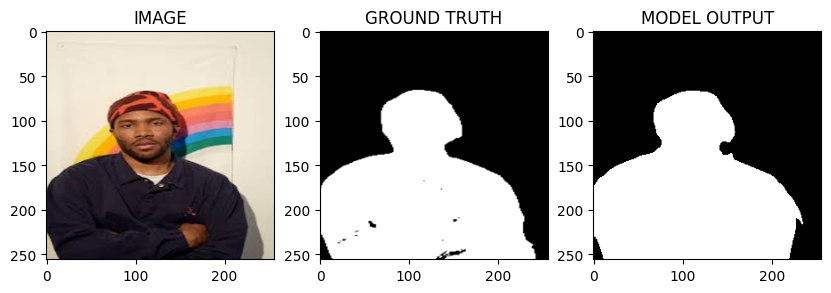

In [55]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))